# **<font size="7">` Dependencies (must to run)`</font>**

___

In [1]:
import sys, os, copy
import numpy as np
import matplotlib.pyplot as plt

if sys.platform == 'darwin' :
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

'main root'
main_path = os.path.abspath('../')
ds_root_path =  os.path.join(os.path.abspath('../..'),"ML_DataSet")
sys.path.append(main_path)
import tensorflow as tf
from lib.utils.common import is_path_available
from lib.visualization import Vis_SampleTransform

'basic info'
print(" tensorflow version:",tf.__version__)
print(" numpy version:", np.__version__)
print(" Python version:", sys.version)
print(" sys.platform:", sys.platform)
print(" gpu available:", tf.config.list_physical_devices('GPU'))
print(" sys.path:", sys.path)
is_path_available(ds_root_path)
is_path_available(main_path) 

if  sys.platform == 'win32':
    'xla issue : https://www.qiniu.com/qfans/qnso-68614547#comments'
    #libdevice_path = "C:/Users/yista/anaconda3/envs/rtx_py38_tf2-10_cu118/Library/bin"
    #os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=C:/Users/yista/anaconda3/envs/rtx_py38_tf2-10_cu118/Library/bin"
    libdevice_path = "C:/Users/yista/anaconda3/envs/rtx_py38_tf2-10_cu118/Library/bin"
    is_path_available(libdevice_path)
    os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir="+libdevice_path
    print(os.environ['XLA_FLAGS'])

key : BBoxesFormatTransform, value :<class 'lib.datasets.transforms.bboxes_format_transform.BBoxesFormatTransform'> >
key : ImageResize, value :<class 'lib.datasets.transforms.img_resize.ImageResize'> >
key : RandomPadImageResize, value :<class 'lib.datasets.transforms.img_resize.RandomPadImageResize'> >
key : Albumentations, value :<class 'lib.datasets.transforms.albumentations.Albumentations'> >
key : IdendityTest, value :<class 'lib.datasets.transforms.idendity_test.IdendityTest'> >
key : EnsureTensor, value :<class 'lib.datasets.transforms.ensure_to_tensor.EnsureTensor'> >
key : ImageNormalize, value :<class 'lib.datasets.transforms.img_norm.ImageNormalize'> >
key : RandomBBoxTransform, value :<class 'lib.datasets.transforms.random_bbox_transform.RandomBBoxTransform'> >
key : RandomFlip, value :<class 'lib.datasets.transforms.random_flip.RandomFlip'> >
key : RandomChannelShift, value :<class 'lib.datasets.transforms.random_channel_shift.RandomChannelShift'> >
key : RandomContrast, 

/Users/yistar/opt/anaconda3/envs/tf_metal/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## **<font size="6">`HyperParams`</font>**

In [15]:
'MODEL Type'
MODEL_TYPE = 'mvla_Det'
PROJECT_NAME = 'YOLOv8'
MODEL_INPUT_SIZE_HW = (640,640)
MODEL_INPUT_SIZE_WH = MODEL_INPUT_SIZE_HW[::-1]
NUM_POSE_KPS = 17
USE_DFL = True

'Global Settings'
USE_MIXED_PRECISION = True if sys.platform != 'darwin' else False
BATCH_SIZE = 128
PREFETCH_SIZE = 4
BATCH_NORM_EPSILON = 1e-5  #torch  :  bn_eps = 1e-5,  tensorflow : bn_eps = 1e-3
BATCH_NORM_MOMENTUM = 0.9  #torch  :  bn_momentum = 0.9,  tensorflow : bn_momentum = 0.99
CODEC_PARALLEL_ITERS = BATCH_SIZE  #parallel_iterations
CV_TRANS_PARALLEL_ITERS = BATCH_SIZE  #parallel_iterations

'Training'
TOTAL_EPOCHS = 400
WARMUP_EPOCHS = TOTAL_EPOCHS//10
LR = 1e-3 # to checj

"path"
PATH_BACKBONE_FEATURE_VEC = None
PATH_TO_SAVE_MODEL = None
PATH_TO_SAVE_EMA_MODEL = None
PATH_TO_LOAD_MODEL = None
PATH_TO_LOAD_EMA_MODEL= None

## **<font size="6">`Mixed Precision (Optional)`</font>**

In [3]:
from tensorflow.keras import mixed_precision
if USE_MIXED_PRECISION :
    policy = mixed_precision.Policy('mixed_float16')
else:
    policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float32
Variable dtype: float32


## **<font size="6">`tfrec train/val data path`</font>**

In [4]:
'dataset root'
ds_main_path =  os.path.join(ds_root_path,"COCO-WholeBody")
is_path_available(ds_main_path)

'train/ val dataset path --- multi poses'
val_mp_tfrec_dir = os.path.join(ds_main_path, "tfrecords_multi_poses_val")
train_mp_tfrec_dir = os.path.join(ds_main_path, "tfrecords_multi_poses_train")

'verify whether tfrecords_dir is exist'
is_path_available(val_mp_tfrec_dir)
is_path_available(train_mp_tfrec_dir)

successfully connect floder  : 
/Volumes/Extreme Pro/deep_learning/ML_DataSet/COCO-WholeBody

successfully connect floder  : 
/Volumes/Extreme Pro/deep_learning/ML_DataSet/COCO-WholeBody/tfrecords_multi_poses_val

successfully connect floder  : 
/Volumes/Extreme Pro/deep_learning/ML_DataSet/COCO-WholeBody/tfrecords_multi_poses_train



True

## **<font size="6">`save / load .h5  path `</font>**

In [5]:
'pretrained model lib'
lib_main_path =  os.path.join(os.path.abspath('../..'),"trained", MODEL_TYPE, PROJECT_NAME)
is_path_available(lib_main_path)

successfully connect floder  : 
/Volumes/Extreme Pro/deep_learning/trained/mvla_Det/YOLOv8



True

# **<font size="6">` 1. Build Dataloader`</font>**


## **<font size="5">`Train data pipeline`</font>**

/Volumes/Extreme Pro/deep_learning/project_sample_V0.7.3/lib/datasets/tfds_builder.py:92: UserWarning: codec is None, you cannot gen targets used in traaining, but test_mode to review data is ok @pose_dataloader
  warnings.warn(


successfully connect floder  : 
/Volumes/Extreme Pro/deep_learning/ML_DataSet/COCO-WholeBody/tfrecords_multi_poses_train

samples_in_tfrec : 4302 @ <file_00-4302.tfrec>
samples_in_tfrec : 4507 @ <file_01-4507.tfrec>
samples_in_tfrec : 4417 @ <file_02-4417.tfrec>
samples_in_tfrec : 4301 @ <file_03-4301.tfrec>
samples_in_tfrec : 4278 @ <file_04-4278.tfrec>
samples_in_tfrec : 4356 @ <file_05-4356.tfrec>
samples_in_tfrec : 4633 @ <file_06-4633.tfrec>
samples_in_tfrec : 4633 @ <file_07-4633.tfrec>
samples_in_tfrec : 4624 @ <file_08-4624.tfrec>
samples_in_tfrec : 4538 @ <file_09-4538.tfrec>
samples_in_tfrec : 4323 @ <file_10-4323.tfrec>
samples_in_tfrec : 4345 @ <file_11-4345.tfrec>
samples_in_tfrec : 4397 @ <file_12-4397.tfrec>
samples_in_tfrec : 4474 @ <file_13-4474.tfrec>
num_TotalSamples: 62128
successfully connect floder  : 
/Volumes/Extreme Pro/deep_learning/ML_DataSet/COCO-WholeBody/tfrecords_multi_poses_train


 ----------------pipeline_cfg  (< ith > --- key : value)  ---------------

/Volumes/Extreme Pro/deep_learning/project_sample_V0.7.3/lib/datasets/tfds_builder.py:260: UserWarning: test_mode cannot support training !!!!!!!!!! @pose_dataloader
  warnings.warn("test_mode cannot support training !!!!!!!!!! @pose_dataloader")



 ----------------pipeline_cfg  (< ith > --- key : value)   @explore_samples-------------------
< 1 >  --- RandomFlip : <lib.datasets.transforms.random_flip.RandomFlip object at 0x7fce080eedf0>
< 2 >  --- ImageResize : <lib.datasets.transforms.img_resize.ImageResize object at 0x7fce102ce370>
< 3 >  --- EnsureTensor : <lib.datasets.transforms.ensure_to_tensor.EnsureTensor object at 0x7fb84805f5e0>
< 4 >  --- DataAdapter : <function dataloader.GenerateTargets.<locals>.<lambda> at 0x7fcac8248310>
--------------------------------------------------------------------------------


==========Pack data type : Dict[str,Tensor] --Test Mode ============= 
img ----- TensorSpec(shape=(128, 640, 640, 3), dtype=tf.uint8, name=None)
kpts ----- None
bboxes ----- TensorSpec(shape=(128, 18, 4), dtype=tf.float32, name=None)
labels ----- TensorSpec(shape=(128, 18), dtype=tf.int32, name=None)
src_img ----- RaggedTensorSpec(TensorShape([128, None, None, 3]), tf.uint8, 2, tf.int64)
src_bboxes ----- RaggedTens

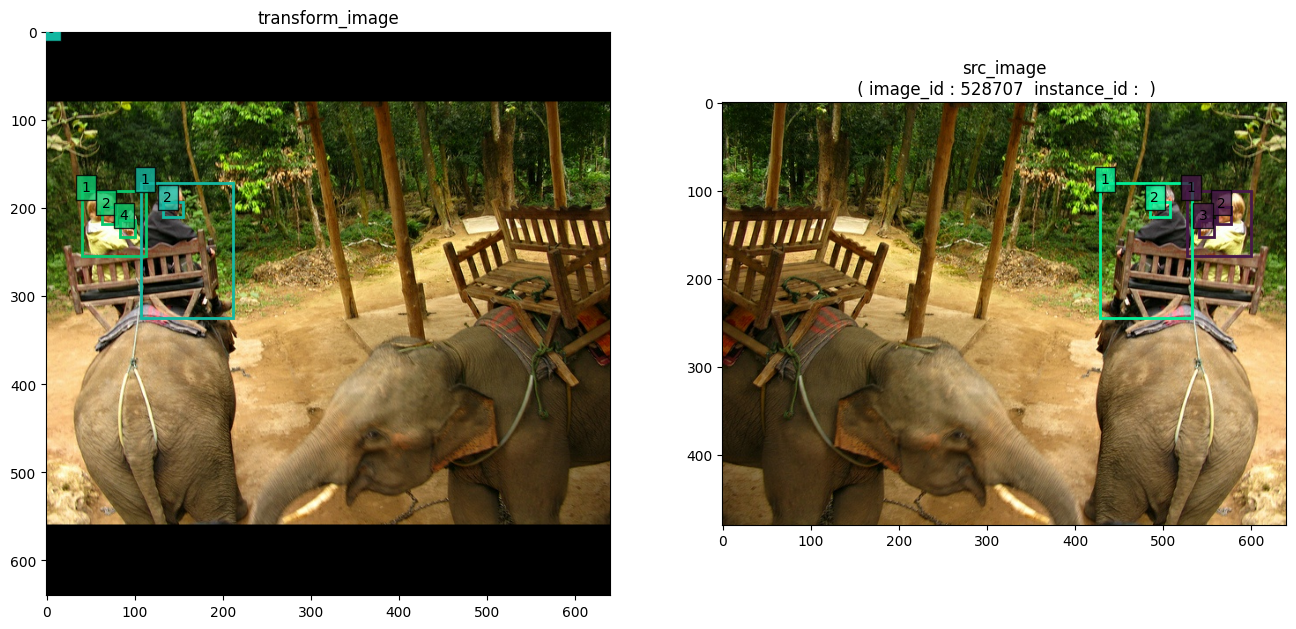

In [17]:
import copy
from lib.Registers import DATASETS
from lib.datasets.transforms import PackInputTensorTypeSpec


tfrec_train_dataset = dict(
    type = 'Parser_CocoMultiPoseTFRec', 
    data_root = train_mp_tfrec_dir,
    is_whole_body_boxes = True,
    sel_kpt_idx  = [],
)

flip_cfg = dict(
    type='RandomFlip',prob=0.5,
    labels_flip  = {1:1, 2:2, 3:4, 4:3} 
)

train_reszie_img_cfg = dict(
    type='ImageResize',
    resized_shape = (640,640),
    symmetric_padding_prob = 0.5
)   

train_dataloader_cfg =  dict(
    type = 'dataloader',
    batch_size = BATCH_SIZE,
    prefetch_size = PREFETCH_SIZE,
    shuffle  =  True,
    tfrec_datasets_list = [tfrec_train_dataset],
    augmenters = [flip_cfg, train_reszie_img_cfg],
    codec = None,
    ensure_to_tensor = True,
    parallel_iterations = CV_TRANS_PARALLEL_ITERS,
    vis_fn = Vis_SampleTransform(
        figsize = (16, 8),
        sel_batch_ids  = [0]
    )
)

train_tfds_builder = DATASETS.build(
    copy.deepcopy(train_dataloader_cfg)
)
batch_train_dataset = train_tfds_builder.GenerateTargets(    
    test_mode = False, 
    unpack_x_y_sample_weight= False, 
    ds_weights = None
)

"pipeline cfg"
train_tfds_builder.get_pipeline_cfg()
"JUST TO EXPLORE SAMPLES"
train_tfds_builder.explore_samples(take_batch_num=1)
#train_tfds_builder.execution_time()


### **<font size="5">`val data pipeline`</font>**

successfully connect floder  : 
/Volumes/Extreme Pro/deep_learning/ML_DataSet/COCO-WholeBody/tfrecords_multi_poses_val

samples_in_tfrec : 2693 @ <file_00-2693.tfrec>
num_TotalSamples: 2693
successfully connect floder  : 
/Volumes/Extreme Pro/deep_learning/ML_DataSet/COCO-WholeBody/tfrecords_multi_poses_val


 ----------------pipeline_cfg  (< ith > --- key : value)   @explore_samples-------------------
< 1 >  --- ImageResize : <lib.datasets.transforms.img_resize.ImageResize object at 0x7fd2612c35e0>
< 2 >  --- EnsureTensor : <lib.datasets.transforms.ensure_to_tensor.EnsureTensor object at 0x7fbad81c54c0>
< 3 >  --- DataAdapter : <function dataloader.GenerateTargets.<locals>.<lambda> at 0x7fd26a53ec10>
--------------------------------------------------------------------------------


==========Pack data type : Dict[str,Tensor] --Test Mode ============= 
img ----- TensorSpec(shape=(128, 640, 640, 3), dtype=tf.uint8, name=None)
kpts ----- None
bboxes ----- TensorSpec(shape=(128, 41, 4), d

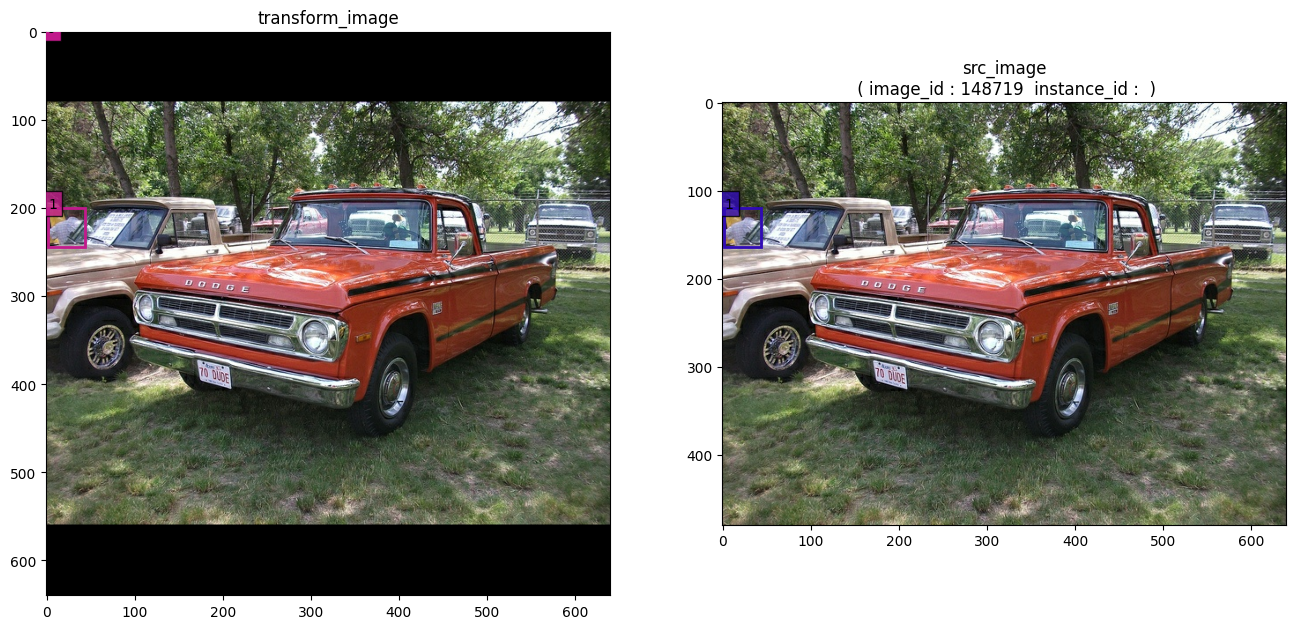

In [19]:
tfrec_val_dataset = dict(
    type = 'Parser_CocoMultiPoseTFRec', 
    data_root = val_mp_tfrec_dir,
    is_whole_body_boxes = True,
    sel_kpt_idx  = [],
)

val_resize_img_cfg = dict(
    type='ImageResize',
    resized_shape = (640,640),
    symmetric_padding_prob = 1.
)   

val_dataloader_cfg =  dict(
    type = 'dataloader',
    batch_size = BATCH_SIZE,
    prefetch_size = PREFETCH_SIZE,
    shuffle  =  True,
    tfrec_datasets_list = [tfrec_val_dataset],
    augmenters = [val_resize_img_cfg],
    codec = None,
    ensure_to_tensor = True,
    parallel_iterations = CV_TRANS_PARALLEL_ITERS,
    vis_fn = Vis_SampleTransform(
        figsize = (16, 8),
        sel_batch_ids  = [0]
    )
)

val_tfds_builder = DATASETS.build(
    copy.deepcopy(val_dataloader_cfg)
)
batch_val_dataset = val_tfds_builder.GenerateTargets(    
    test_mode=False, 
    unpack_x_y_sample_weight= False, 
    ds_weights =None
)
"JUST TO EXPLORE SAMPLES"
val_tfds_builder.explore_samples(take_batch_num=1)

# **<font size="6">` 2. Task HumanDet`</font>**

---

## **<font size="6">`2-1. GELAN Modeling`</font>**

### <font size="5">`Build Model`</font>

In [28]:
from lib.models import BaseModel
depth_multiple =1  # model depth multiple
width_multiple = 0.25 # layer channel multiple


GELAN_cfg = dict(
        type = 'GELAN',
        model_input_shape=(640,640),
        deepen_factor = depth_multiple,
        widen_factor = width_multiple,
        use_depthwise = False,
        out_feat_indices = [3,4,5],
        bn_epsilon = BATCH_NORM_EPSILON,
        bn_momentum = BATCH_NORM_MOMENTUM,
        activation = 'silu',
        data_preprocessor = dict(
            type='ImgNormalization', 
            img_mean = [0.485, 0.456, 0.406],  
            img_std = [0.229, 0.224, 0.225]
        ),
        deploy = False,
        name =  'YOLOv9_Backbone'
)

neck_cfg = dict(
        type = 'PathAggregationFPN_RepNCSPELAN4',
        csp_depth  = depth_multiple,
        only_topdown = False,
        use_spp_elan  = True,
        deploy = False,
        bn_epsilon = BATCH_NORM_EPSILON,
        bn_momentum = BATCH_NORM_MOMENTUM,
        activation = 'silu',
        name='YOLOv9_Neck'
)

head_cfg = dict(
        type ='YOLO_AnchorFreeHead',
        reg_max= 16, 
        num_classes=80,
        bbox_conv_groups = 4,
        activation = 'silu',
        bn_epsilon = BATCH_NORM_EPSILON,
        bn_momentum = BATCH_NORM_MOMENTUM,
        deploy =  None,
        with_auxiliary_regression_channels = True,
        scope_marks = '_',
        wrapped_model = False,
        name='YOLOv9_Head'
)

# aux_module_cfg = dict(
#         type = 'YOLOv9_AuxBranch',
#         reg_max = 16, 
#         num_classes =80,
#         with_auxiliary_regression_channels = True,            
#         deepen_factor= depth_multiple,
#         widen_factor= width_multiple,
#         expand_ratio = 0.5,
#         activation ='silu',
#         bn_epsilon = BATCH_NORM_EPSILON,
#         bn_momentum = BATCH_NORM_MOMENTUM,    
#         deploy = None,
#         name='YOLOv9AuxBranch'
# )

YOLOv9_det = BaseModel(
        backbone = GELAN_cfg,
        neck = neck_cfg,  
        head = head_cfg,
        extract_layres = [],
        # aux_extract_layres = ['Silence', 'StageP3_Out', 'StageP4_Out', 'StageP5_Out'],
        # aux_module  = aux_module_cfg,
        codec = None,
        optimizer  = None,
        metrics = None,
        losses = None,
        pretrained_weights_path  = None,
        name= "GELANDet"
)   

YOLOv9_det.count_params()

2329968

### <font size="5">` Model Summary (option)`</font>

In [29]:
YOLOv9_det.summary(250)

Model: "GELANDet"
__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                                     Output Shape                                           Param #                       Connected to                                                                       
 input_7 (InputLayer)                                                             [(None, 640, 640, 3)]                                  0                             []                                                                                 
                                                                                                                                                                                                                                     

### <font size="5">` Mini Training Test (Optional)`</font>

In [ ]:
YOLOv9_det.fit(
    batch_train_dataset,
    epochs=5, 
    steps_per_epoch=20
)

## **<font size="6">`  2-2. Model Training`</font>**

---

In [ ]:
train_steps_per_epoch = train_tfds_builder.ds_TotalSamples
val_steps_per_epoch = val_tfds_builder.ds_TotalSamples
print(train_steps_per_epoch, val_steps_per_epoch)

62128 2693


### <font size="5">` Load Model Pretrained-Weights`</font>

In [ ]:
h5_file_name = 'det_YOLOv8-s_b64-400e_4cls-640x640.h5'
file_path = os.path.join(lib_main_path,h5_file_name)
is_path_available(file_path)
YOLOv9_det.load_weights(file_path,skip_mismatch=False,by_name=True)

successfully connect floder  : 
/Volumes/Extreme Pro/deep_learning/trained/mvla_Det/YOLOv8/det_YOLOv8-s_b64-400e_4cls-640x640.h5



True

### <font size="5">`Callbacks`</font>

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from lib.callbacks import CosineDecayScheduler, EMA_ModelCheckpoint
train_steps_per_epoch = train_tfds_builder.ds_steps_per_epoch
val_steps_per_epoch = val_tfds_builder.ds_steps_per_epoch
STEPS_PER_EPOCH = train_steps_per_epoch

ema_h5_file_name = 'HumanDet_YOLOv8-n_b128-400e_coco-640x640_EMA.h5'
ema_file_path = os.path.join(lib_main_path, ema_h5_file_name)
h5_file_name = 'HumanDet_YOLOv8-n_b128-400e_coco-640x640.h5'
h5_file_path = os.path.join(lib_main_path,h5_file_name)


callbacks = [
    EarlyStopping(
        monitor = 'loss',  # "val_loss"
        patience=20
    ),
    EMA_ModelCheckpoint(
        ema_h5_file_name,
        decay = 0.999, 
        val_use_ema_weights = False,
        verbose=1
    ) ,
    ModelCheckpoint(
        filepath = file_path,
        monitor="loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=True
    ),
    TensorBoard(
        log_dir='logs'
    ),
]



NameError: name 'file_path' is not defined

### **<font size="5">` Training`</font>**

In [ ]:
train_steps_per_epoch = train_tfds_builder.ds_TotalSamples
val_steps_per_epoch = val_tfds_builder.ds_TotalSamples

YOLOv8_det.fit(
    batch_train_dataset,
    epochs=400, 
    validation_data=batch_val_dataset,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    callbacks=callbacks
)

## **<font size="6">`  2-3. Evaluation`</font>**

In [ ]:
from lib.visualization.det_visualizer import draw_bboxes_with_tf_nmsed_decode
for data in batch_val_dataset.take(3):
    imgs = data['image']
    tf_nms_decode_res = YOLOv8_det.predict(
        imgs 
    )
    #print(type(tf_nms_decode_res))
    #print(tf_nms_decode_res)
    imgs = tf.cast(data['image'], dtype=tf.float32)
    draw_bboxes_with_tf_nmsed_decode(imgs, tf_nms_decode_res)